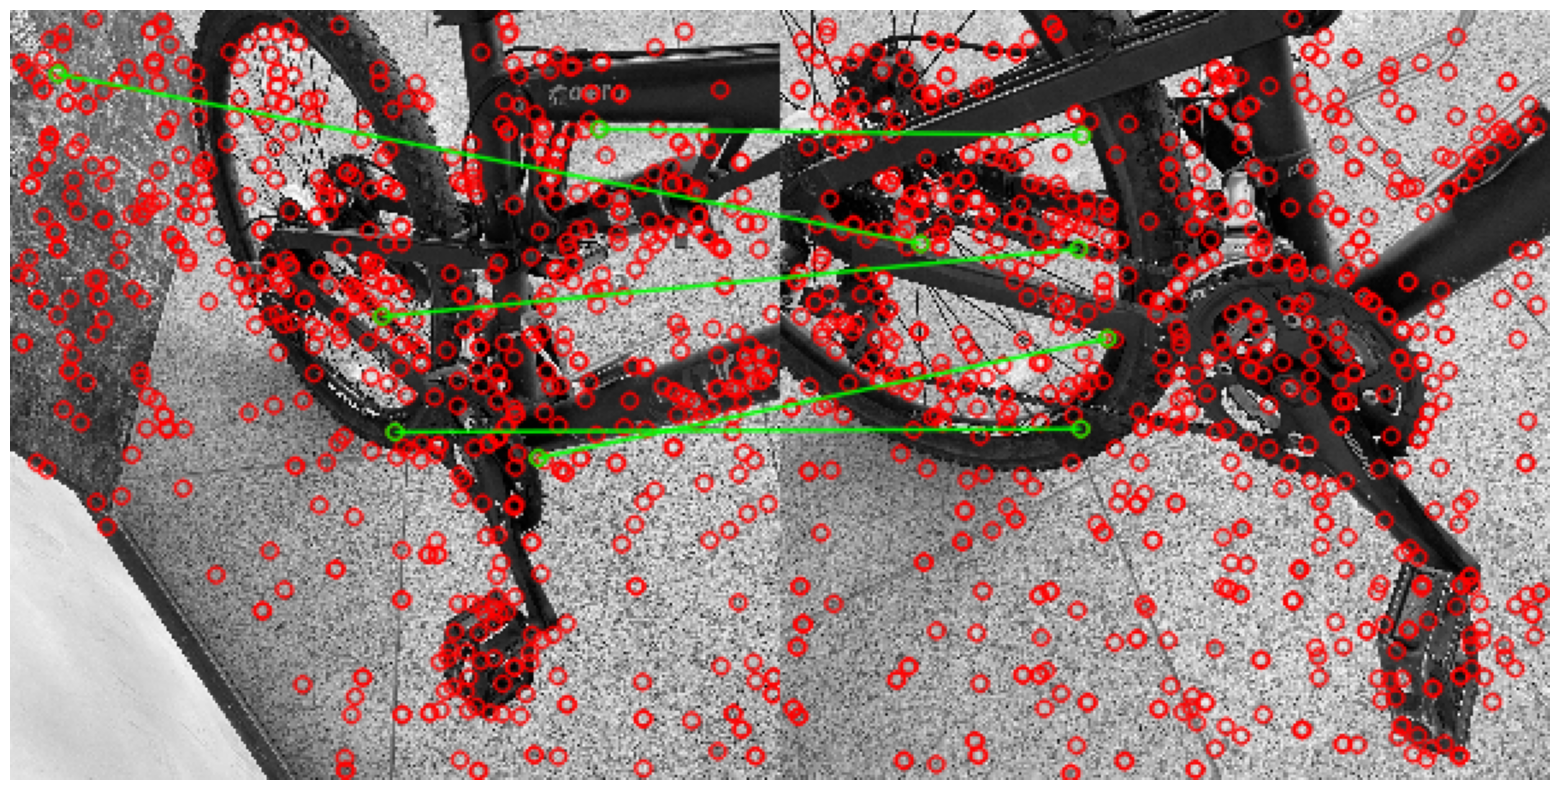

In [11]:
import cv2
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('photos/IMG_3558.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('photos/IMG_3557.jpg', cv2.IMREAD_GRAYSCALE)

img1 = cv2.resize(img1, (300, 300))
img2 = cv2.resize(img2, (300, 300))


# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0, 0] for i in range(len(matches))]

# Ratio test
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=cv2.DrawMatchesFlags_DEFAULT)

img_matches = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

plt.figure(figsize=(20, 10))
plt.imshow(img_matches)
plt.axis('off')
plt.show()


호모그래피 영상 매치 (서로 다른 각도에서 찍은 사진에 유용)

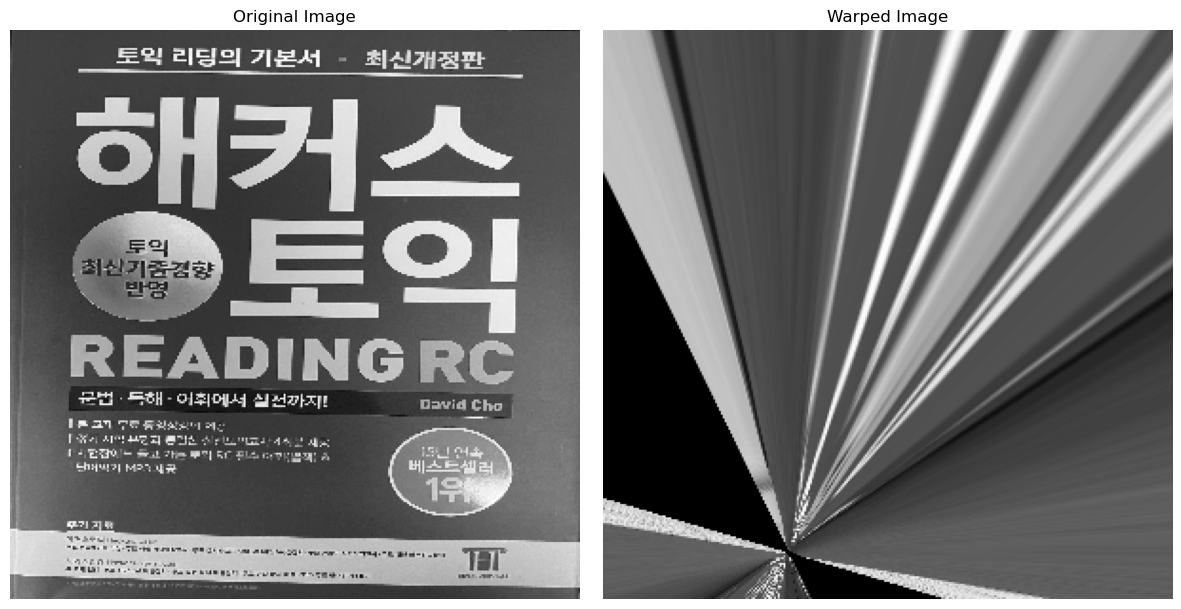

In [14]:
# 새로운 이미지 불러오기
import numpy as np

img1_latest = cv2.imread('photos/IMG_3560.JPG', cv2.IMREAD_GRAYSCALE)
img2_latest = cv2.imread('photos/IMG_3559.JPG', cv2.IMREAD_GRAYSCALE)

# 이미지 리사이즈
img1_resized_latest = cv2.resize(img1_latest, (300, 300))
img2_resized_latest = cv2.resize(img2_latest, (300, 300))

# SIFT 특징점 검출
kp1_latest, des1_latest = sift.detectAndCompute(img1_resized_latest, None)
kp2_latest, des2_latest = sift.detectAndCompute(img2_resized_latest, None)

# FLANN 기반 매칭
matches_latest = flann.knnMatch(des1_latest, des2_latest, k=2)

# 좋은 매칭만 선택
good_matches_latest = [m for m, n in matches_latest if m.distance < 0.85 * n.distance]

# 매칭된 특징점에서 좌표를 추출
src_pts_latest = np.float32([kp1_latest[m.queryIdx].pt for m in good_matches_latest]).reshape(-1, 1, 2)
dst_pts_latest = np.float32([kp2_latest[m.trainIdx].pt for m in good_matches_latest]).reshape(-1, 1, 2)

# 호모그래피 행렬 계산
H_latest, _ = cv2.findHomography(src_pts_latest, dst_pts_latest, cv2.RANSAC, 5.0)

# 호모그래피를 사용하여 이미지 왜곡
warped_img_latest = cv2.warpPerspective(img1_resized_latest, H_latest, (img2_resized_latest.shape[1], img2_resized_latest.shape[0]))

# 결과 이미지 표시
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img2_resized_latest, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(warped_img_latest, cmap='gray')
plt.title("Warped Image")
plt.axis('off')
plt.tight_layout()
plt.show()


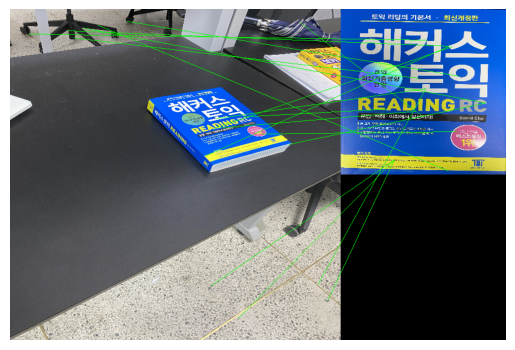

In [21]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

resolution = 600


# 첫 번째 이미지 불러오고 크롭
img1 = cv.imread('photos/IMG_3560.JPG')
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img1 = cv.resize(img1, (resolution, resolution))
gray1 = cv.resize(gray1, (resolution, resolution))

# 두 번째 이미지 불러오고 그레이스케일로 변환
img2 = cv.imread('photos/IMG_3559.JPG')
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
img2 = cv.resize(img2, (300, 300))
gray2 = cv.resize(gray2, (300, 300))

# SIFT 특징 추출
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# FLANN 기반 디스크립터 매칭 생성
flann_matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = flann_matcher.knnMatch(des1, des2, 2)

# 매칭 임계값 설정
T = 0.7
good_matches = []
for m, n in knn_matches:
    if m.distance < T * n.distance:
        good_matches.append(m)

# 좋은 매칭점의 좌표 추출
points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])


# 호모그래피 계산
H, _ = cv.findHomography(points1, points2, cv.RANSAC)

# 첫 번째 이미지와 두 번째 이미지 크기
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

# 첫 번째 이미지의 꼭지점 좌표
corners1 = np.float32([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]]).reshape(-1, 1, 2)

# 호모그래피 변환을 통해 두 번째 이미지의 꼭지점 좌표 계산
corners2 = cv.perspectiveTransform(corners1, H)

# 두 이미지 합치기
combined_image = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
combined_image[:h1, :w1] = img1
combined_image[:h2, w1:] = img2

# 좋은 매칭점 그리기
for m in good_matches:
    pt1 = tuple(map(int, kp1[m.queryIdx].pt))
    pt2 = tuple(map(int, kp2[m.trainIdx].pt))
    cv.line(combined_image, pt1, (pt2[0] + w1, pt2[1]), (0, 255, 0), 1)

# 이미지 표시
plt.imshow(cv.cvtColor(combined_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


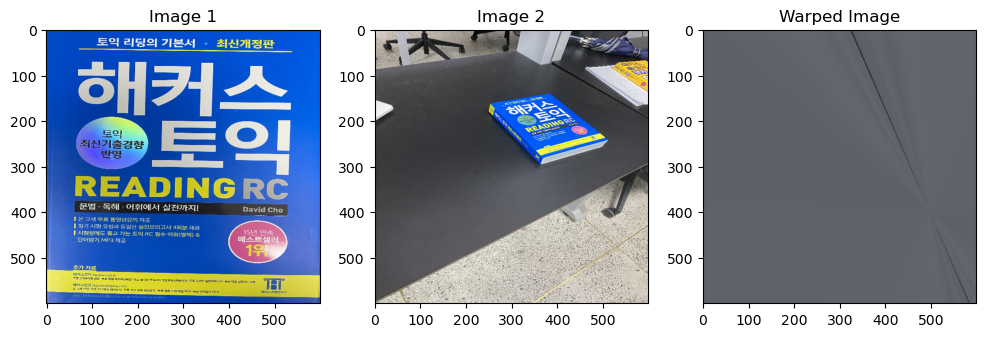

In [29]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

resolution = 600

# 첫 번째 이미지 불러오고 크롭
img1 = cv.imread('photos/IMG_3559.JPG')
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img1 = cv.resize(img1, (resolution, resolution))
gray1 = cv.resize(gray1, (resolution, resolution))

# 두 번째 이미지 불러오고 크롭
img2 = cv.imread('photos/IMG_3560.JPG')
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
img2 = cv.resize(img2, (resolution, resolution))
gray2 = cv.resize(gray2, (resolution, resolution))

# SIFT 특징 추출
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# FLANN 기반 디스크립터 매칭 생성
flann_matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = flann_matcher.knnMatch(des1, des2, 2)

# 매칭 임계값 설정
T = 0.7
good_matches = []
for m, n in knn_matches:
    if m.distance < T * n.distance:
        good_matches.append(m)

# 좋은 매칭점의 좌표 추출
points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 호모그래피 계산
H, _ = cv.findHomography(points1, points2, cv.RANSAC)

# 호모그래피 행렬 형식 변경
H = H.astype(np.float32)

# 두 번째 이미지를 첫 번째 이미지 공간에 매핑
warped_image = cv.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))

# 이미지 표시
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB)), plt.title('Image 1')
plt.subplot(132), plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB)), plt.title('Image 2')
plt.subplot(133), plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB)), plt.title('Warped Image')
plt.show()
